# Violent and Sexual Crime Rates by Municipality: The Netherlands, 2018

In [1]:
# Libararies
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data & Pre-processing

### Data about registered violent and sexual crime rates
The data is sourced from the Centraal Bureau voor de Statistiek, Den Haag/Heerlen and can be accessed from https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=84468NED&_theme=395.

In [5]:
# Access the crime data about 
df = pd.read_csv(r'C:\Users\murat\Downloads\84468NED_TypedDataSet_04012021_122231.csv', sep=';' , index_col=[0])
# Retain the columns of the analysis
df.drop(['WijkenEnBuurten', 'SoortRegio_2', 'Indelingswijziging_4', 'AantalInwoners_5',
       'TotaalVermogenVernielingEnGeweld_26', 'TotaalVermogensmisdrijven_27',
       'TotaalDiefstalUitWoningSchuurED_28',
       'VernielingMisdrijfTegenOpenbareOrde_29'], 
        axis=1, inplace=True)

# Remove white spaces from the categorical data
df['Codering_3'] = df['Codering_3'].str.strip()
df['Gemeentenaam_1'] = df['Gemeentenaam_1'].str.strip()

# Rename the columns
df.rename(columns = {'Gemeentenaam_1':'Municipality', 
                     'Codering_3' : 'Code', 
                     'GeweldsEnSeksueleMisdrijven_30' : 'Violent_and_sexual_crime'},
          inplace = True)
df.head(5)

,Municipality,Code,Violent_and_sexual_crime
ID,,,
0,Aa en Hunze,GM1680,3.0
1,Aa en Hunze,WK168000,2.0
2,Aa en Hunze,BU16800000,2.0
3,Aa en Hunze,BU16800009,0.0
4,Aa en Hunze,WK168001,1.0


#### Dataframe with groupby

In [6]:
# Obtain a dataframe of municipality by thier total crime rates recorded per 1000 inhabitants
df_groupby = df.groupby('Municipality')['Violent_and_sexual_crime'].sum().to_frame(name='Total_violent_and_sexual_crime').reset_index()
df_groupby

,Municipality,Total_violent_and_sexual_crime
0,'s-Gravenhage,2583.0
1,'s-Hertogenbosch,646.0
2,Aa en Hunze,151.0
3,Aalburg,45.0
4,Aalsmeer,61.0
...,...,...
375,Zundert,46.0
376,Zutphen,230.0
377,Zwartewaterland,129.0
378,Zwijndrecht,277.0


### Data for geographic information
The data is accessed from www.pdok.nl for the official district boundaries of the Netherlands in 2018

In [ ]:
# Access the geographic information
geodata = gpd.read_file(r"C:\Users\murat\Downloads\WijkBuurtkaart_2018_v3\gemeente_2018_v3.shp")
# Examine the data
geodata.head()

In [13]:
# Prepare the geographic data for merging:
## Clean white space and change data type from object to string 
geodata['GM_NAAM'] = geodata['GM_NAAM'].str.strip()
geodata["GM_NAAM"] = geodata["GM_NAAM"].astype('str')

### Merge Data

In [14]:
# Join the geodataframe with the cleaned up csv dataframe
merged = geodata.set_index('GM_NAAM').join(df_groupby.set_index('Municipality')).reset_index()
merged

## Analysis
Perform data visualization for Total Violent and Sexual Crime rate per 1000 inhabitants in each municipality, according to police records.

### Municipalities with the highest crime rates

In [20]:
# Display the municipalities with the highest crime rates of violent and sexual crime
crimebym = df.groupby('Municipality')['Violent_and_sexual_crime'].sum().sort_values(ascending=False)
crimebym = pd.DataFrame(crimebym)
print("Number of Municipality: ", len(crimebym))
crimebym.head()

Number of Municipality:  380


,Violent_and_sexual_crime
Municipality,
Amsterdam,8427.0
's-Gravenhage,2583.0
Haarlemmermeer,2320.0
Tilburg,2280.0
Arnhem,1831.0


Among 380 municipality recordings, the ones with the highest rates for Violent & Sexual Crime per 1000 inhabitants are identified in the following order: Amsterdam (8427), 's-Gravenhage (2583), Haarlemmermeer (2320), Tilburg (2280), and Arnhem (1831).

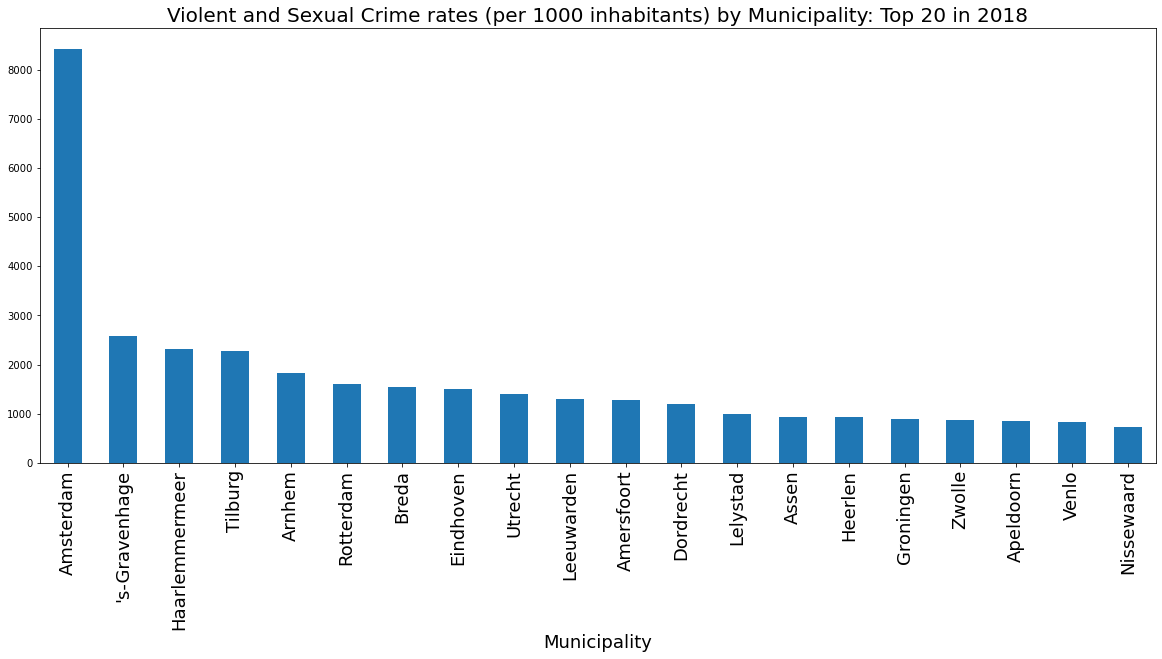

In [26]:
# Display the bar chart figure of the top 20 municipalities in term of crime rates
crimebym.head(20).plot(kind= 'bar', legend=False, figsize=(20,8))
plt.title('Violent and Sexual Crime rates (per 1000 inhabitants) by Municipality: Top 20 in 2018', 
          fontweight = 30, fontsize = 20)
plt.xlabel('Municipality', fontsize = 18)
plt.xticks(rotation = 90, fontsize = 18)
plt.show()

### Mapping

#### Generating a static choropleth map of the Netherlands using the violent and sexual crime data

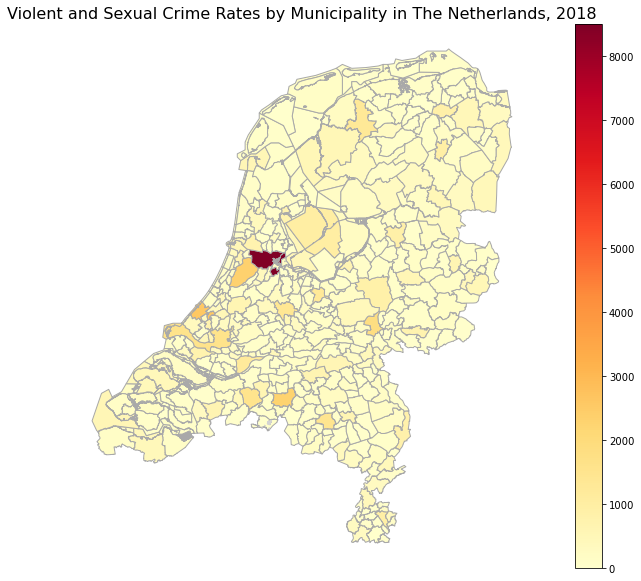

In [33]:
# Determine the size of the figure
fig, ax = plt.subplots(1, 1, figsize=[15,10])

# Create the map
nl_map = merged.plot(column='Total_violent_and_sexual_crime', ax=ax, cmap = 'YlOrRd', edgecolor='darkgrey',
                      missing_kwds={'color': 'lightgrey', 'edgecolor': 'lightgrey', 
                                    'hatch': '///', 'label': 'Missing values'})
# Do not display information on the axis
ax.axis('off')

# Create a colorbar as a legend
legend = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=8500))
fig.colorbar(legend)


# Add a title
ax.set_title('Violent and Sexual Crime Rates by Municipality in The Netherlands, 2018', fontsize=16)

# Save figure in the directory and show
fig.savefig('NL_crime_rates.png', dpi=300)
plt.show()

#### Generating an interactive map

In [25]:
# Convert the merged file (Geopandas Dataframe) to GeoJSON format
import json
#Read data to json.
merged_json = json.loads(merged.to_json())

#Convert to String like object.
json_data = json.dumps(merged_json)

In [ ]:
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource,  HoverTool, LinearColorMapper, ColorBar
from bokeh.palettes import Magma11 as palette
from bokeh.layouts import row, column

  
# Input GeoJSON source
geosource = GeoJSONDataSource(geojson = json_data)

# Define a sequential color palette (Magma).
palette = tuple(reversed(palette))

# Instantiate LinearColorMapper to linearly map the data in term of the sequence of colors.
color_mapper = LinearColorMapper(palette = palette)

# Add hover tool
hover = HoverTool(tooltips = [('Mn','@index'), ('Crime', '@Total_violent_and_sexual_crime')])

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, width = 500, height = 30,
                     border_line_color=None, location = (0,0), orientation = 'horizontal')


#Create figure object.
p = figure(title = 'Violent and sexual crime rates (per 1000 inhabitants) by municipality, 2018', plot_height = 900 , plot_width = 800, 
           x_axis_location=None, y_axis_location=None, toolbar_location = None, tools = [hover])

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Total_violent_and_sexual_crime', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.5, fill_alpha = 1)

# Specify layout
p.add_layout(color_bar, 'below')

# Display plot inline in Jupyter notebook
output_notebook()

# Save figure in the directory
fig.savefig('NL_crime_rates_interactive_map.png', dpi=300)

#Display plot
show(p)